# Import

In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import shutil

In [2]:
import windows_utils_hf as util
import helpers

In [3]:
from sklearn import model_selection, metrics

import torch
import torchvision
from torchvision.transforms import v2
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from efficientnet_pytorch import EfficientNet
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

from PIL import Image
import re
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
# Import utility functions
from cjm_pandas_utils.core import markdown_to_pandas
from cjm_pil_utils.core import resize_img
from cjm_pytorch_utils.core import set_seed, pil_to_tensor, tensor_to_pil, get_torch_device, denorm_img_tensor

# Import HuggingFace Datasets dependencies
from datasets import load_dataset

from torchvision.transforms import v2
from torchvision.io import read_image

In [5]:
from sklearn import metrics

# Load Data

In [6]:
repo_fp = Path('./data/')
noh_fp = repo_fp / 'NOH'

## NOH Data

In [7]:
noh_data = pd.read_csv('./metadata/image_dataset_3class.csv', index_col=0)
noh_data = noh_data[noh_data['data']=='NOH'].reset_index(drop=True)
noh_data

,data,patient_id,img_id,label,dataset,img_path,filename,new_img_path,new_label
0,NOH,122,NOH_122,4,train,/content/drive/MyDrive/Colab Notebooks/AI4Thyr...,IMG_20230228_082014.jpg,processed_img/NOH_122/IMG_20230228_082014.jpg,2
1,NOH,122,NOH_122,4,train,/content/drive/MyDrive/Colab Notebooks/AI4Thyr...,IMG_20230228_082225.jpg,processed_img/NOH_122/IMG_20230228_082225.jpg,2
2,NOH,122,NOH_122,4,train,/content/drive/MyDrive/Colab Notebooks/AI4Thyr...,IMG_20230228_082229.jpg,processed_img/NOH_122/IMG_20230228_082229.jpg,2
3,NOH,122,NOH_122,4,train,/content/drive/MyDrive/Colab Notebooks/AI4Thyr...,IMG_20230228_081641.jpg,processed_img/NOH_122/IMG_20230228_081641.jpg,2
4,NOH,122,NOH_122,4,train,/content/drive/MyDrive/Colab Notebooks/AI4Thyr...,IMG_20230228_082243.jpg,processed_img/NOH_122/IMG_20230228_082243.jpg,2
...,...,...,...,...,...,...,...,...,...
2043,NOH,24,NOH_24,5,test,/content/drive/MyDrive/Colab Notebooks/AI4Thyr...,IMG_20230116_082639.jpg,processed_img/NOH_24/IMG_20230116_082639.jpg,2
2044,NOH,24,NOH_24,5,test,/content/drive/MyDrive/Colab Notebooks/AI4Thyr...,IMG_20230116_082508.jpg,processed_img/NOH_24/IMG_20230116_082508.jpg,2
2045,NOH,24,NOH_24,5,test,/content/drive/MyDrive/Colab Notebooks/AI4Thyr...,IMG_20230116_082541.jpg,processed_img/NOH_24/IMG_20230116_082541.jpg,2
2046,NOH,24,NOH_24,5,test,/content/drive/MyDrive/Colab Notebooks/AI4Thyr...,IMG_20230116_082615.jpg,processed_img/NOH_24/IMG_20230116_082615.jpg,2


# Stats

In [8]:
noh_data[['new_label']].value_counts().sort_index()

new_label
0              97
1             285
2            1666
Name: count, dtype: int64

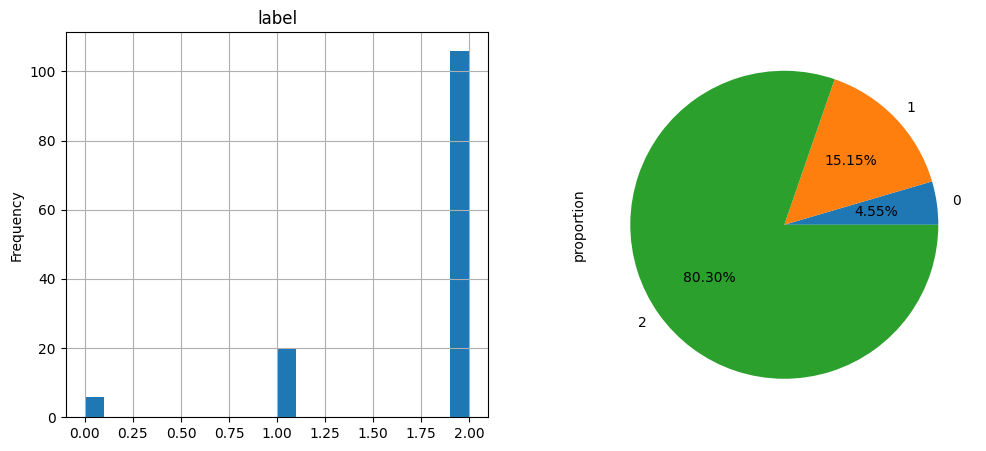

In [9]:
noh_sum = noh_data[['patient_id', 'new_label']].drop_duplicates()
fig, axs = plt.subplots(1,2,figsize=(12,5))
noh_sum['new_label'].plot(kind='hist', bins=20, title='label',ax=axs[0], grid=True)
noh_sum['new_label'].value_counts(dropna=False, normalize=True).fillna('NA').sort_index().plot(kind='pie', autopct='%.2f%%', ax=axs[1])
plt.gca().spines[['top', 'right',]].set_visible(False)

## Per patient

In [10]:
noh_data.groupby(['dataset','new_label'])['patient_id'].nunique().to_frame().reset_index().pivot_table(index='dataset', columns='new_label', values='patient_id').astype(int)

new_label,0,1,2
dataset,,,
test,2,5,32
train,2,9,45
val,2,6,29


## Per Image

In [11]:
noh_data.groupby(['dataset','new_label'])['filename'].nunique().to_frame().reset_index().pivot_table(index='dataset', columns='new_label', values='filename').astype(int)

new_label,0,1,2
dataset,,,
test,35,69,540
train,27,131,673
val,35,85,453


In [12]:
img_ds = noh_data[['new_img_path', 'new_label', 'dataset']]
img_ds = img_ds.rename(columns={'new_img_path': 'img_path'})
img_ds['img_path'] = img_ds['img_path'].apply(lambda x: os.path.join(str(repo_fp), x.replace('./','')))
img_ds

,img_path,new_label,dataset
0,data/processed_img/NOH_122/IMG_20230228_082014...,2,train
1,data/processed_img/NOH_122/IMG_20230228_082225...,2,train
2,data/processed_img/NOH_122/IMG_20230228_082229...,2,train
3,data/processed_img/NOH_122/IMG_20230228_081641...,2,train
4,data/processed_img/NOH_122/IMG_20230228_082243...,2,train
...,...,...,...
2043,data/processed_img/NOH_24/IMG_20230116_082639.jpg,2,test
2044,data/processed_img/NOH_24/IMG_20230116_082508.jpg,2,test
2045,data/processed_img/NOH_24/IMG_20230116_082541.jpg,2,test
2046,data/processed_img/NOH_24/IMG_20230116_082615.jpg,2,test


## Transform

In [13]:
plt.rcParams["savefig.bbox"] = 'tight'

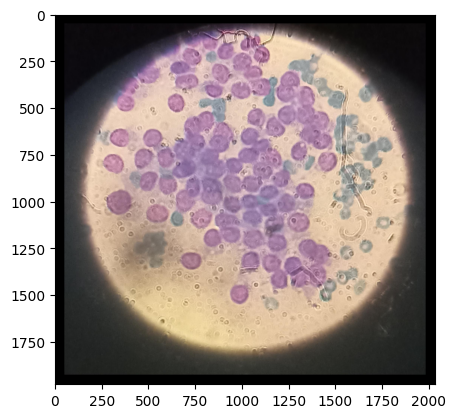

In [14]:
img_path = img_ds.iloc[0]['img_path']
# img = read_image(img_path)
img = Image.open(img_path)
plt.imshow(img)

In [15]:
# prompt: generate train and test transform


# Create transforms for train and test data
train_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize(224, antialias=True),
    v2.RandomCrop(224),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomHorizontalFlip(p=0.5),
    # v2.AutoAugment(v2.AutoAugmentPolicy.CIFAR10), # [v2.AutoAugmentPolicy.CIFAR10, v2.AutoAugmentPolicy.IMAGENET, v2.AutoAugmentPolicy.SVHN]
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize(224, antialias=True),
    v2.CenterCrop(size=224),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

### Inspect train and test transform

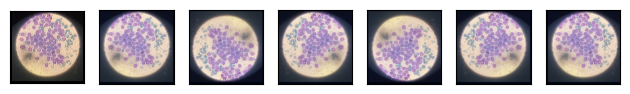

In [16]:
train_outs = [train_transform(img) for i in range(5)]
test_out = test_transform(img)
helpers.plot([img, test_out] + train_outs)

## Batch size

In [17]:
batch_size=16

# Dataset and DataLoader

In [18]:
# prompt: i need pytorch dataset that read from dataframe
class ThyroidDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.dataframe['img_path'][idx]
        label = self.dataframe['new_label'][idx]
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        return image, label


In [19]:
train_df = img_ds[img_ds['dataset']=='train'].reset_index(drop=True)
val_df = img_ds[img_ds['dataset']=='val'].reset_index(drop=True)
test_df = img_ds[img_ds['dataset']=='test'].reset_index(drop=True)

In [20]:
trainset = ThyroidDataset(train_df, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=8)

In [21]:
valset = ThyroidDataset(val_df, transform=test_transform)
valoader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=False, num_workers=8)

In [22]:
testset = ThyroidDataset(test_df, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False, num_workers=8)

##  Inspect Image

In [23]:
norm_stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

data/processed_img/NOH_69/IMG_20230201_164852.jpg


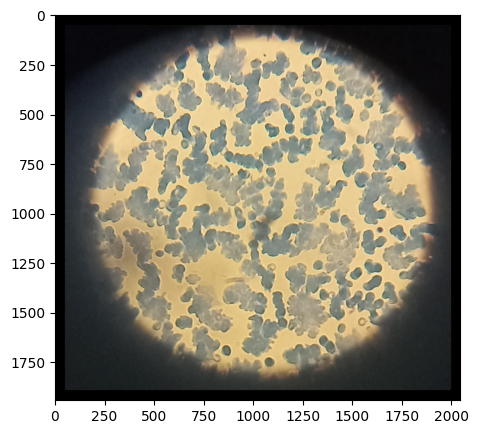

In [24]:
# Select a random item from the dataset
import numpy as np
item_path = np.random.choice(train_df['img_path'])
print(item_path)
sample_img = Image.open(item_path)
# Display the image
fig = plt.figure(figsize=(10,5))
plt.imshow(sample_img)
plt.show()

Feature batch shape: torch.Size([16, 3, 224, 224])
Labels batch shape: torch.Size([16])


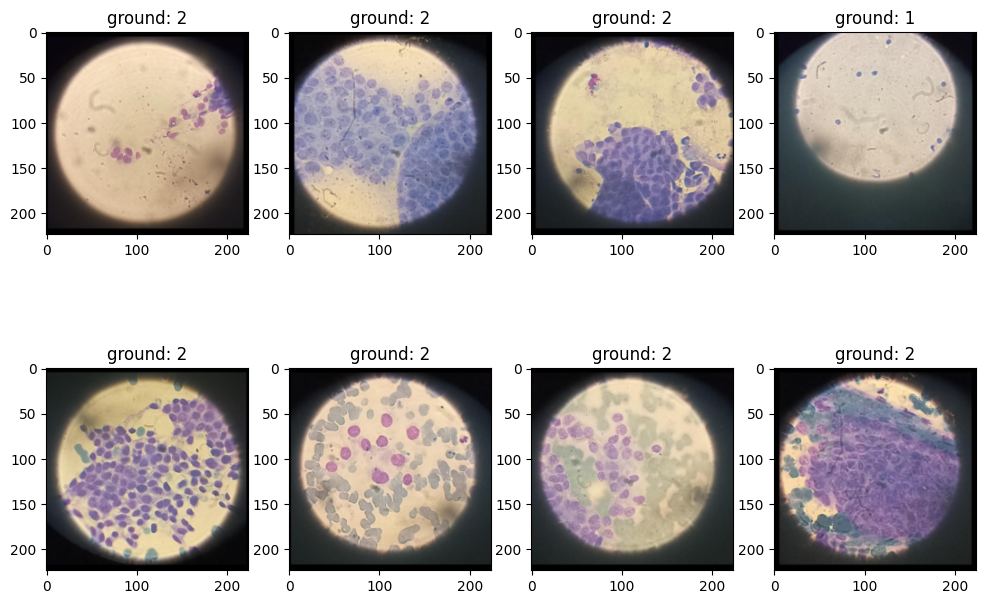

In [25]:
train_features, train_labels = next(iter(trainloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
indx = 0
f, axarr = plt.subplots(2, 4, figsize=(12, 8))
for r in range(0, 2):
  for c in range(0, 4):
    img = train_features[indx].squeeze()
    label = train_labels[indx]
    axarr[r, c].imshow(tensor_to_pil(denorm_img_tensor(img, *norm_stats)))
    axarr[r, c].set_title(f'ground: {label}')
    indx+=1
#tensor_to_pil(denorm_img_tensor(train_dataset[10][0], *norm_stats))

## Device and Tensorboard

In [26]:
if torch.cuda.is_available():
    # Get the number of available GPUs
    num_gpus = torch.cuda.device_count()

    print(f"Number of available GPUs: {num_gpus}")

    # List information about each GPU
    for i in range(num_gpus):
        gpu_info = torch.cuda.get_device_properties(i)
        print(f"GPU {i}: {gpu_info.name}")
        print(f"   Compute Capability: {gpu_info.major}.{gpu_info.minor}")
        print(f"   Total Memory: {gpu_info.total_memory / (1024 ** 3):.2f} GB\n")
else:
    print("No GPUs available.")


Number of available GPUs: 2
GPU 0: NVIDIA GeForce RTX 2080
   Compute Capability: 7.5
   Total Memory: 7.79 GB

GPU 1: NVIDIA GeForce RTX 2080
   Compute Capability: 7.5
   Total Memory: 7.79 GB



In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [28]:
# prompt: use tensorboard to log
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/thyroid_noh_3class')

2024-02-06 21:12:03.575397: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-06 21:12:03.575433: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-06 21:12:03.576477: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-06 21:12:03.581968: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-06 21:12:04.332315: W tensorflow/comp

# Load model

In [29]:
# prompt: train this trainloader using efficient-net model. this is classification problem
model = EfficientNet.from_pretrained('efficientnet-b0')

Loaded pretrained weights for efficientnet-b0


In [30]:
model._fc = nn.Linear(model._fc.in_features, train_df['new_label'].nunique())
model.to(device);

In [31]:
model._fc

Linear(in_features=1280, out_features=3, bias=True)

In [32]:
num_epochs = 15
best_val_acc = 0.0

# Criterion, Optimizer, Scheduler

In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.3, patience=3, verbose=True)

In [34]:
# AdamW optimizer; includes weight decay for regularization
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, eps=1e-5)

# Learning rate scheduler; adjusts the learning rate during training
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, total_steps=num_epochs*len(trainloader))

In [35]:
def report_clf(preds_ts, outs_ts):
    np_preds = [i.numpy() for i in preds_ts]
    np_outs = [i.numpy() for i in outs_ts]
    
    np_preds = np.array([i for s in np_preds for i in s])
    np_outs = np.array([i for s in np_outs for i in s])
    assert np_preds.shape == np_outs.shape

    print(metrics.classification_report(np_outs, np_preds))

    cm = metrics.confusion_matrix(np_outs, np_preds)
    d = metrics.ConfusionMatrixDisplay(cm)
    d.plot()
    plt.show()

In [36]:
def evaluate_dataset(model, ds_loader):
    model.eval()
    loss = 0.0
    acc = 0.0
    preds = []
    outs = []
    for batch_idx, (data, target) in enumerate(tqdm(ds_loader)):
        data, target = data.to(device), target.to(device)
        # target = target.clamp(min=0, max=5)
        output = model(data)
        loss = criterion(output, target)
        loss += loss.item()
        acc += accuracy_score(output.cpu().argmax(dim=1), target.cpu())
        # f1 += f1_score(output.argmax(dim=1), target)
        # auc += roc_auc_score(target, output[:, 1])
        preds.append(output.cpu().argmax(dim=1))
        outs.append(target.cpu())
        
    loss /= len(testloader)
    acc /= len(testloader)
    # f1 /= len(testloader)
    # auc /= len(testloader)
    print('Test Loss: {:.4f} \tTest Acc: {:.4f}'.format(loss, acc))
    report_clf(preds, outs)
    return acc,preds, outs

# If exist model, then evaluate before write new

In [37]:
def run_predict_testset():
    test_features, test_labels = next(iter(testloader))
    # Make a prediction with the model
    class_names = [0,1,2,3,4,5]
    with torch.no_grad():
        preds = model(test_features.to(device))
        #print(preds)
        print(f"Feature batch shape: {test_features.size()}")
        print(f"Labels batch shape: {test_labels.size()}")
        indx = 0
        f, axarr = plt.subplots(3, 3, figsize=(12, 8))
        for r in range(0, 3):
            for c in range(0, 3):
                img_tensor = test_features[indx]
                label = class_names[test_labels[indx].numpy()]
                print('Label: ', label)
                # Scale the model predictions to add up to 1
                pred_scores = torch.softmax(preds[indx], dim=0)
                # Get the highest confidence score
                confidence_score = pred_scores.max()
                # Get the class index with the highest confidence score and convert it to the class name
                pred_class = class_names[torch.argmax(pred_scores)]
                print('Predicted: ', pred_class)
                axarr[r, c].imshow(tensor_to_pil(denorm_img_tensor(img_tensor, *norm_stats)))
                axarr[r, c].set_title(f"ground: {label}, pred: {pred_class}, conf: {confidence_score*100:.2f}%")
                indx+=1
        plt.tight_layout()
        plt.show()

In [38]:
model_folder = 'model/noh_3class/'
baseline_model_path = os.path.join(model_folder, 'efficientnet-b0-clf.pt')
if not os.path.exists(model_folder):
    os.makedirs(model_folder, exist_ok=True)

  0%|          | 0/36 [00:00<?, ?it/s]

Test Loss: 0.0295 	Test Acc: 0.7645
              precision    recall  f1-score   support

           0       1.00      0.29      0.44        35
           1       0.62      0.47      0.54        85
           2       0.90      0.99      0.94       453

    accuracy                           0.87       573
   macro avg       0.84      0.58      0.64       573
weighted avg       0.87      0.87      0.85       573



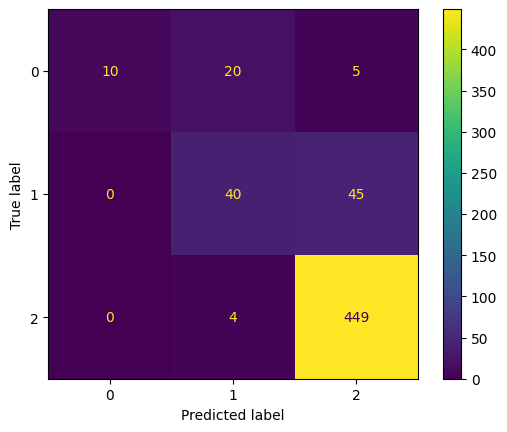

Feature batch shape: torch.Size([16, 3, 224, 224])
Labels batch shape: torch.Size([16])
Label:  2
Predicted:  2
Label:  2
Predicted:  2
Label:  2
Predicted:  2
Label:  2
Predicted:  2
Label:  2
Predicted:  2
Label:  2
Predicted:  2
Label:  2
Predicted:  2
Label:  2
Predicted:  2
Label:  2
Predicted:  2


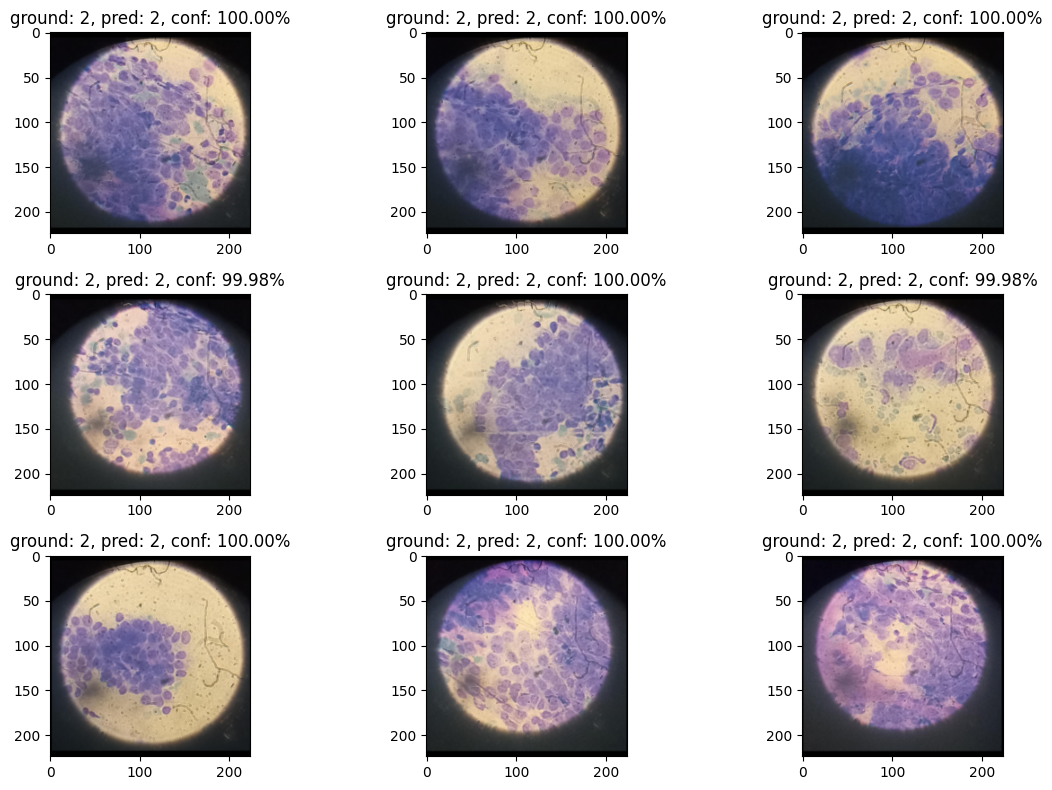

In [39]:
# reload model
model_fp = Path(baseline_model_path)
if model_fp.exists():
    model.load_state_dict(torch.load(str(model_fp), map_location=torch.device(device)))
    best_val_acc = evaluate_dataset(model, valoader)[0]
    run_predict_testset()

In [40]:
best_val_acc

0.7645403377110694

# Train model

In [41]:
# for batch_idx, (data, target) in enumerate(tqdm(trainloader)):
#     data, target = data.to(device), target.to(device)

In [42]:
# for batch_idx, (data, target) in enumerate(tqdm(valoader)):
#     data, target = data.to(device), target.to(device)

In [43]:
# for batch_idx, (data, target) in enumerate(tqdm(testloader)):
#     data, target = data.to(device), target.to(device)

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 0 	Train Loss: 0.1635 	Train Acc: 0.9447 	Val Loss: 1.0984 	Val Acc: 0.8118


  0%|          | 0/41 [00:00<?, ?it/s]

Test Loss: 0.0000 	Test Acc: 0.8338
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        35
           1       0.29      0.39      0.33        69
           2       0.92      0.94      0.93       540

    accuracy                           0.83       644
   macro avg       0.40      0.44      0.42       644
weighted avg       0.80      0.83      0.82       644



/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

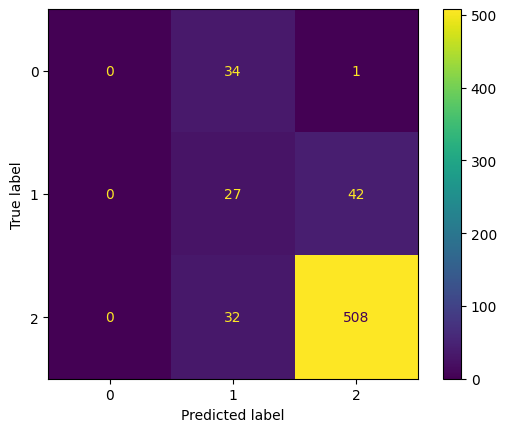

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 1 	Train Loss: 0.1368 	Train Acc: 0.9506 	Val Loss: 0.7112 	Val Acc: 0.8295


  0%|          | 0/41 [00:00<?, ?it/s]

Test Loss: 0.0001 	Test Acc: 0.8354
              precision    recall  f1-score   support

           0       0.75      0.17      0.28        35
           1       0.31      0.39      0.34        69
           2       0.92      0.93      0.92       540

    accuracy                           0.83       644
   macro avg       0.66      0.50      0.52       644
weighted avg       0.84      0.83      0.83       644



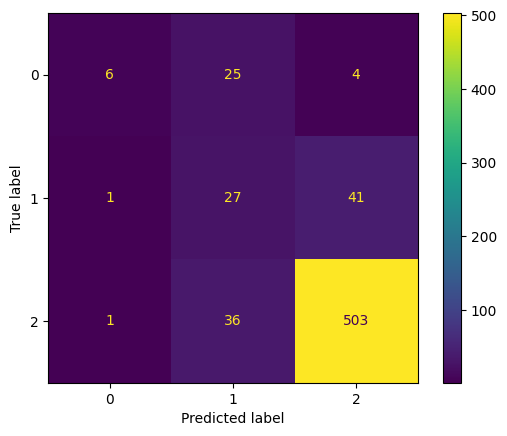

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/36 [00:40<?, ?it/s]

Epoch: 2 	Train Loss: 0.1295 	Train Acc: 0.9541 	Val Loss: 2.9192 	Val Acc: 0.8243


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 3 	Train Loss: 0.1344 	Train Acc: 0.9651 	Val Loss: 0.8653 	Val Acc: 0.8443


  0%|          | 0/41 [00:00<?, ?it/s]

Test Loss: 0.0000 	Test Acc: 0.8247
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        35
           1       0.30      0.48      0.37        69
           2       0.93      0.92      0.92       540

    accuracy                           0.82       644
   macro avg       0.41      0.47      0.43       644
weighted avg       0.81      0.82      0.81       644



/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

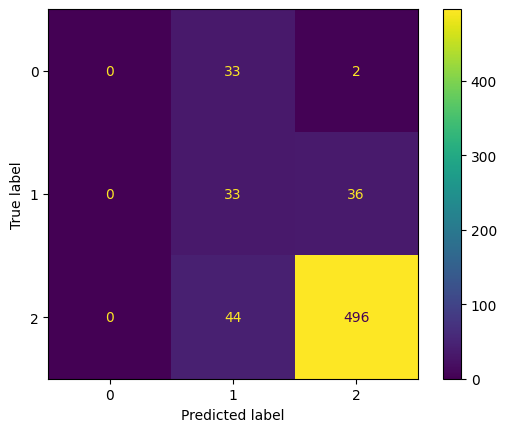

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 4 	Train Loss: 0.1268 	Train Acc: 0.9602 	Val Loss: 0.7262 	Val Acc: 0.8385


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 00006: reducing learning rate of group 0 to 3.0000e-04.
Epoch: 5 	Train Loss: 0.0676 	Train Acc: 0.9748 	Val Loss: 0.8979 	Val Acc: 0.8524


  0%|          | 0/41 [00:00<?, ?it/s]

Test Loss: 0.0000 	Test Acc: 0.8491
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        35
           1       0.48      0.16      0.24        69
           2       0.86      0.99      0.92       540

    accuracy                           0.85       644
   macro avg       0.45      0.38      0.39       644
weighted avg       0.77      0.85      0.80       644



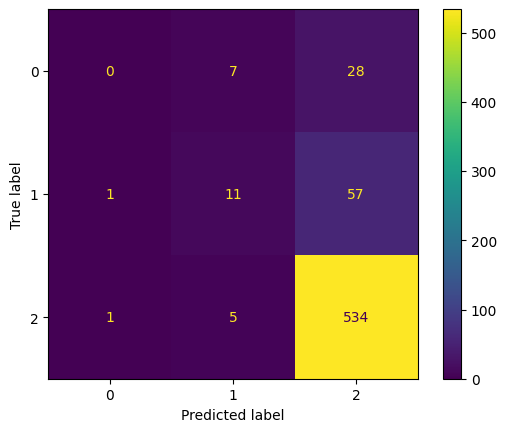

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 6 	Train Loss: 0.0585 	Train Acc: 0.9832 	Val Loss: 0.8132 	Val Acc: 0.8385


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f200c0b3100>
Traceback (most recent call last):
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f200c0b3100>
Traceback (most recent call last):
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutd

Epoch: 7 	Train Loss: 0.0203 	Train Acc: 0.9940 	Val Loss: 0.8468 	Val Acc: 0.8329


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 8 	Train Loss: 0.0118 	Train Acc: 0.9952 	Val Loss: 0.9218 	Val Acc: 0.8299


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 00010: reducing learning rate of group 0 to 9.0000e-05.
Epoch: 9 	Train Loss: 0.0193 	Train Acc: 0.9940 	Val Loss: 0.9711 	Val Acc: 0.8109


  0%|          | 0/52 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f200c0b3100>
Traceback (most recent call last):
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f200c0b3100>
Traceback (most recent call last):
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutd

  0%|          | 0/36 [00:00<?, ?it/s]

^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError^: 
can only test a child processAssertionError
: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f200c0b3100>
Traceback (most recent call last):
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    
 if w.is_alive():      ^^^^^^^^^
    
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^^^           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f200c0b3100>
Traceback (most recent call last):
  File "/home/quan/

Epoch: 10 	Train Loss: 0.0120 	Train Acc: 0.9952 	Val Loss: 0.8727 	Val Acc: 0.8256


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 11 	Train Loss: 0.0092 	Train Acc: 0.9964 	Val Loss: 0.9322 	Val Acc: 0.8208


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 12 	Train Loss: 0.0031 	Train Acc: 1.0000 	Val Loss: 0.9309 	Val Acc: 0.8208


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f200c0b3100>
Traceback (most recent call last):
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
    Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7f200c0b3100>  ^^^
^Traceback (most recent call last):
^  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
^    ^self._shutdown_workers()^^
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
^^    ^if w.is_alive():

  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/multiprocessing/process.py", line 160, in is

Epoch 00014: reducing learning rate of group 0 to 2.7000e-05.
Epoch: 13 	Train Loss: 0.0194 	Train Acc: 0.9952 	Val Loss: 0.9641 	Val Acc: 0.8239


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 14 	Train Loss: 0.0058 	Train Acc: 0.9988 	Val Loss: 0.9579 	Val Acc: 0.8260


In [44]:
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    for batch_idx, (data, target) in enumerate(tqdm(trainloader)):
        data, target = data.to(device), target.to(device)
        # target = target.clamp(min=0, max=5)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += accuracy_score(output.cpu().argmax(dim=1), target.cpu())
    train_loss /= len(trainloader)
    train_acc /= len(trainloader)

    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    for batch_idx, (data, target) in enumerate(tqdm(valoader)):
        data, target = data.to(device), target.to(device)
        # target = target.clamp(min=0, max=5)
        output = model(data)
        loss = criterion(output, target)
        val_loss += loss.item()
        val_acc += accuracy_score(output.cpu().argmax(dim=1), target.cpu())
    val_loss /= len(valoader)
    val_acc /= len(valoader)

    scheduler.step(val_loss)

    print('Epoch: {} \tTrain Loss: {:.4f} \tTrain Acc: {:.4f} \tVal Loss: {:.4f} \tVal Acc: {:.4f}'.format(
        epoch, train_loss, train_acc, val_loss, val_acc))
    writer.add_scalar('Train/Loss', loss.item(), epoch * len(trainloader) + batch_idx)
    writer.add_scalar('Train/Accuracy', train_acc, epoch * len(trainloader) + batch_idx)
    writer.add_scalar('Validation/Loss', val_loss, epoch * len(valoader) + batch_idx)
    writer.add_scalar('Validation/Accuracy', val_acc, epoch * len(valoader) + batch_idx)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), baseline_model_path)
        evaluate_dataset(model, testloader)

In [45]:
best_val_acc

0.8524305555555556

# Evaluate

  0%|          | 0/41 [00:00<?, ?it/s]

Test Loss: 0.0000 	Test Acc: 0.7774
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        35
           1       0.23      0.45      0.31        69
           2       0.92      0.86      0.89       540

    accuracy                           0.77       644
   macro avg       0.38      0.44      0.40       644
weighted avg       0.79      0.77      0.78       644



/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

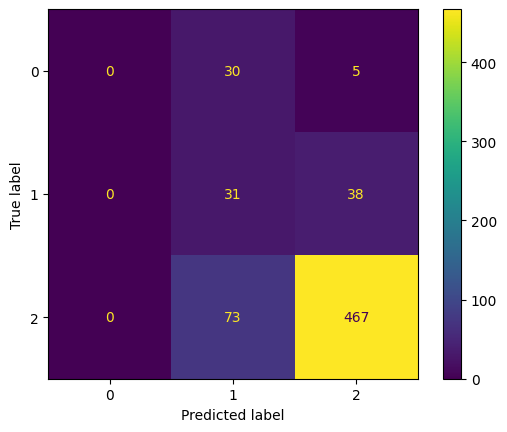

In [46]:
p = evaluate_dataset(model, testloader)